## FCNN with a boolean output indicating the likelihood of the image containing nerve

This is submission 6, got 0.67

In [3]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

In [4]:
_d = np.load('../../data_clean_128_train.npz')
X = _d['X']
Y = _d['Y']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [5]:
print X.shape
print Y.shape

(3906, 128, 128)
(3906, 128, 128)


In [6]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
#train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.25)
X_train = X[train_indices][:,None,:,:]
Y_train_binary = Y_binary[train_indices][:,None]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test_binary = Y_binary[test_indices][:,None]
Y_test = Y[test_indices][:,None,:,:]

In [7]:
print X_train.shape
print Y_train.shape
print Y_train_binary.shape
print X_train.min(), X_train.max()

(3515, 1, 128, 128)
(3515, 1, 128, 128)
(3515, 1)
0.0 1.0


/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


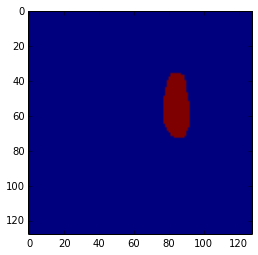

In [8]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

# Keras model

In [9]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 128, 128)


In [10]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [11]:
import theano
print theano.config.device

gpu0


In [12]:
input_img = Input(shape=input_shape)
x = Convolution2D(16, 3, 3, border_mode='same')(input_img)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool1 = Dropout(0.25, name='pool1')(x)

x = Convolution2D(16, 3, 3, border_mode='same')(pool1)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool2 = Dropout(0.25, name='pool2')(x)

x = Convolution2D(32, 3, 3, border_mode='same')(pool2)
x = LeakyReLU()(x)
x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool3 = Dropout(0.25, name='pool3')(x)

# -- binary presence part
x = Convolution2D(16, 3, 3, border_mode='same')(pool3)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool4 = Dropout(0.25, name='pool4')(x)

x = Convolution2D(16, 3, 3, border_mode='same')(pool4)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool5 = Dropout(0.25, name='pool5')(x)

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(pool5)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
outbin = Dense(1, activation='sigmoid', name='outbin')(x)

# -- location map
x = Convolution2D(16, 3, 3, border_mode='same')(pool3)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='sum')
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(
    input=input_img,
    output=[outmap, outbin]
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
model.compile(optimizer='adam', loss='binary_crossentropy',
              loss_weights=[1., 0.01])

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 16, 128, 128)160         input_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)            (None, 16, 128, 128)0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 16, 128, 128)2320        leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [13]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

Train on 3515 samples, validate on 391 samples
Epoch 1/60
3515/3515 [==============================] - 17s - loss: 0.2150 - outmap_loss: 0.2082 - outbin_loss: 0.6889 - val_loss: 0.1113 - val_outmap_loss: 0.1048 - val_outbin_loss: 0.6568
Epoch 2/60
3515/3515 [==============================] - 17s - loss: 0.0890 - outmap_loss: 0.0823 - outbin_loss: 0.6674 - val_loss: 0.0813 - val_outmap_loss: 0.0746 - val_outbin_loss: 0.6697
Epoch 3/60
3515/3515 [==============================] - 16s - loss: 0.0679 - outmap_loss: 0.0613 - outbin_loss: 0.6606 - val_loss: 0.0567 - val_outmap_loss: 0.0501 - val_outbin_loss: 0.6572
Epoch 4/60
3515/3515 [==============================] - 16s - loss: 0.0528 - outmap_loss: 0.0464 - outbin_loss: 0.6422 - val_loss: 0.0477 - val_outmap_loss: 0.0415 - val_outbin_loss: 0.6226
Epoch 5/60
3515/3515 [==============================] - 17s - loss: 0.0452 - outmap_loss: 0.0392 - outbin_loss: 0.5992 - val_loss: 0.0412 - val_outmap_loss: 0.0351 - val_outbin_loss: 0.6067
Epo

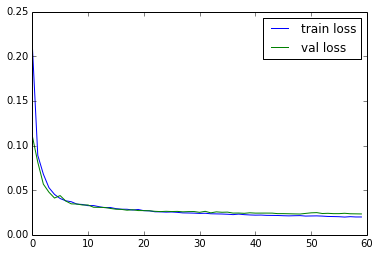

In [14]:
if True:
    json_string = model.to_json()
    open('architecture.json', 'w').write(json_string)
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True, verbose=True)
    
    history = model.fit(
        X_train,
        {'outmap': Y_train, 'outbin': Y_train_binary},
        batch_size=64,
        validation_data=(X_test, {'outmap': Y_test, 'outbin': Y_test_binary}),
        nb_epoch=60,# 40 + 10 + 10 + 5 + 5
        verbose=1,
        shuffle=True,
        callbacks=[model_checkpoint]
    )
    pl.plot(history.history['loss'], label='train loss')
    pl.plot(history.history['val_loss'], c='g', label='val loss')
    pl.legend()
else:
    model_dir = '.'
    model = model_from_json(open(os.path.join(model_dir, 'architecture.json')).read())
    model.load_weights(os.path.join(model_dir, 'weights.h5'))
    model.compile(optimizer='adagrad', loss='mse')
    
    print_summary(model.layers)

In [15]:
if False:
    model_dir = '.'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.hdf5'))

In [19]:
def predict(X):
    Y_pred, Y_pred_binary = model.predict(X)
    Y_pred_binary = Y_pred_binary.squeeze()
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > 0.3
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 100 or Y_pred_binary[i] < 0.5:
            Y_pred[i,:] = 0
    return Y_pred, Y_pred_proba

In [20]:
Y_pred, Y_pred_proba = predict(X_test)

print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)

test set score :  0.651126900451


In [39]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_pred[i], Y_test[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

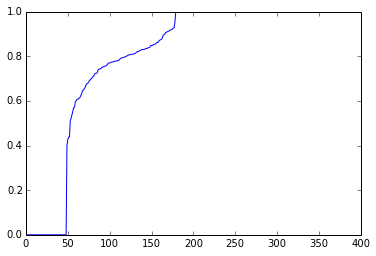

In [40]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


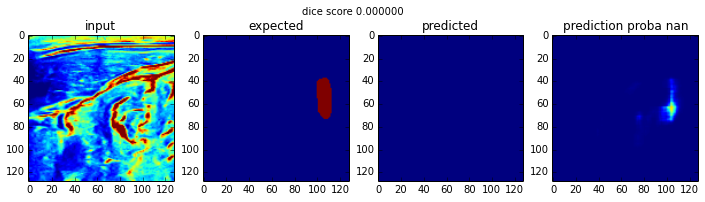

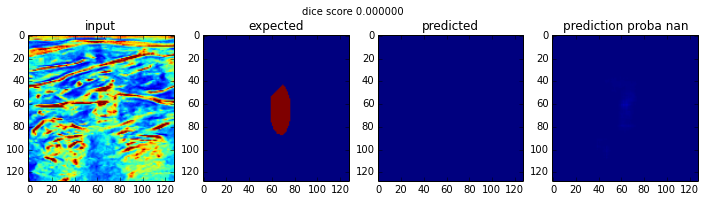

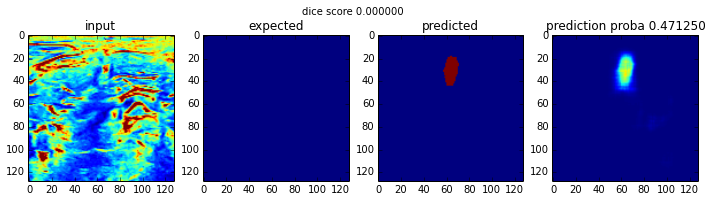

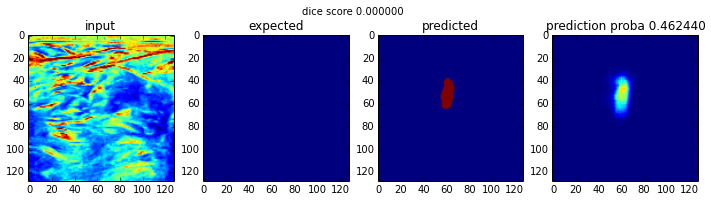

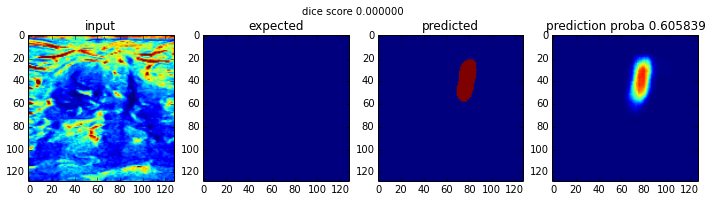

In [41]:
#i = 50
#i = 47

#for i in lowest[-450:-445]:
for i in lowest[:5]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_pred[i], Y_test[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X_test[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y_test[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    
    blob_proba = np.mean(Y_pred_proba[i][Y_pred[i] == 1])
    pl.title('prediction proba %f' % blob_proba)
    pl.imshow(Y_pred_proba[i].squeeze(), vmin=0, vmax=1)

# Run the model on kaggle'7 test set

In [42]:
_d = np.load('../../data_128_test.npz')
X_submit = _d['X']
test_fnames = _d['test_fnames']
Y_pred, Y_pred_proba = predict(X_submit[:,None,:,:])

In [43]:
OUTDIR='../../preds'
if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
utils.mkdir_p(OUTDIR)

for i in range(Y_pred.shape[0]):
    imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
    basename = os.path.splitext(test_fnames[i])[0]
    cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)